In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

In [2]:
from numpy.random import seed
seed(42)

# Загрузка и проверка данных

Загрузка данных:

In [3]:
df = pd.read_csv('neo.csv')

Проверка набора данных:

In [4]:
df.sample(5)

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
20406,3943344,(2019 YT1),0.024241,0.054205,22148.962596,5.028574e+07,Earth,False,25.20,False
74443,3879239,(2019 US),0.012722,0.028447,26477.211836,1.683201e+06,Earth,False,26.60,False
74306,3879244,(2019 UU),0.013322,0.029788,33770.201397,3.943220e+06,Earth,False,26.50,False
45943,2481965,481965 (2009 EB1),0.193444,0.432554,43599.575296,7.346837e+07,Earth,False,20.69,False
62859,3789471,(2017 WJ1),0.044112,0.098637,36398.080883,6.352916e+07,Earth,False,23.90,False


In [5]:
df.shape

(90836, 10)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


Пропущенные значения:

In [7]:
df.isnull().sum()

id                    0
name                  0
est_diameter_min      0
est_diameter_max      0
relative_velocity     0
miss_distance         0
orbiting_body         0
sentry_object         0
absolute_magnitude    0
hazardous             0
dtype: int64

# Предобработка

In [8]:
print(df.orbiting_body.nunique(), df.orbiting_body.unique())

1 ['Earth']


In [9]:
print(df.sentry_object.nunique(), df.sentry_object.unique())

1 [False]


Удалим неинформативные колонки:

- id
- name
- orbiting_body
- sentry_object

In [10]:
df = df.drop(['id', 'name', 'orbiting_body', 'sentry_object'], axis=1)

Переведем колонку hazardous в числа:

In [11]:
df['hazardous'] = df['hazardous'].astype("int")

In [12]:
df.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,1.198271,2.679415,13569.249224,5.483974e+07,16.73,0
1,0.265800,0.594347,73588.726663,6.143813e+07,20.00,1
2,0.722030,1.614507,114258.692129,4.979872e+07,17.83,0
3,0.096506,0.215794,24764.303138,2.543497e+07,22.20,0
4,0.255009,0.570217,42737.733765,4.627557e+07,20.09,1


####Списки с именами разных колонок

In [13]:
df.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,1.198271,2.679415,13569.249224,5.483974e+07,16.73,0
1,0.265800,0.594347,73588.726663,6.143813e+07,20.00,1
2,0.722030,1.614507,114258.692129,4.979872e+07,17.83,0
3,0.096506,0.215794,24764.303138,2.543497e+07,22.20,0
4,0.255009,0.570217,42737.733765,4.627557e+07,20.09,1


Признаки (все числовые):

In [14]:
feature_cols = ['est_diameter_min', 'est_diameter_max', 'relative_velocity', 'miss_distance', 'absolute_magnitude']

Целевая переменная:

In [15]:
target_col = 'hazardous'

Проверка:

In [16]:
assert len(feature_cols) + 1 == df.columns.size

## Посмотрим на распределение признаков и целевой переменной

Гистограммы для числовых признаков

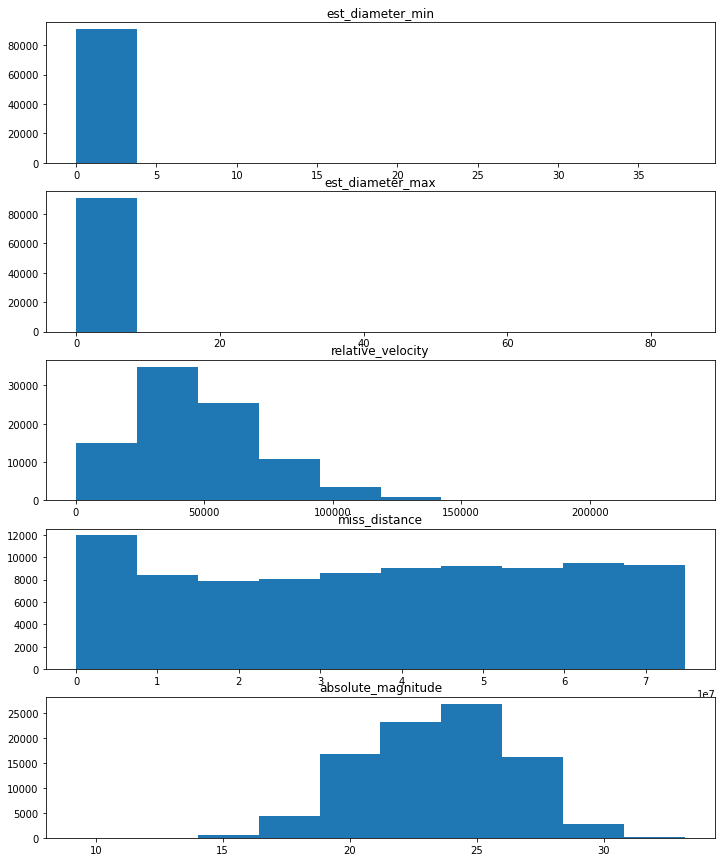

In [17]:
fig, axs = plt.subplots(len(feature_cols))

fig.set_size_inches(12, 15, forward=True)

for i, feature in enumerate(feature_cols):
  axs[i].hist(df[feature])
  axs[i].set_title(feature)
fig.show()

Заметим, что est_diameter_min и est_diameter_max коррелируют между собой, значит, один из признаков нужно удалить

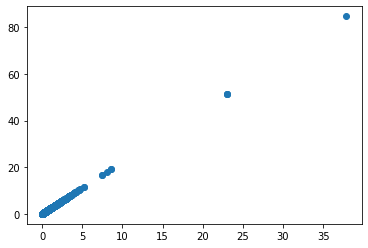

In [18]:
plt.scatter(df.est_diameter_min, df.est_diameter_max);

In [19]:
np.corrcoef(df.est_diameter_min, df.est_diameter_max)

array([[1., 1.],
       [1., 1.]])

In [20]:
df = df.drop('est_diameter_min', axis=1)
feature_cols.remove('est_diameter_min')

Распределение целевой переменной:

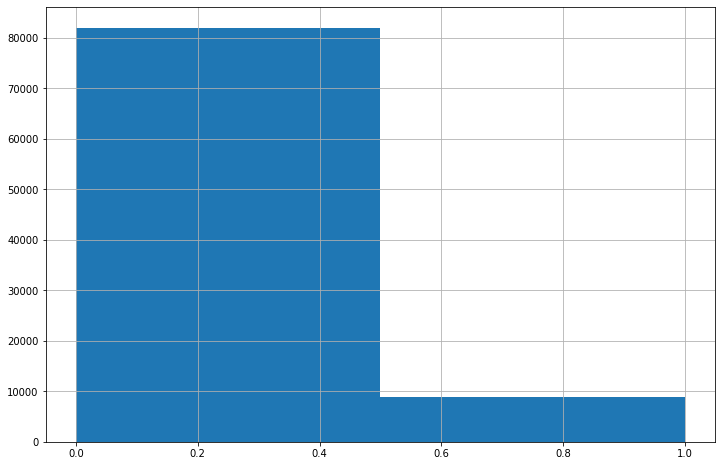

In [21]:
df[target_col].hist(figsize=(12, 8),bins=2);

# Подготовка к обучению

Задачу классификации будем решать с помощью решающих деревьев, проведем сравнение трех разных моделей:
1. Решающее дерево (одно)
2. Случайны лес
3. Градиентный бустинг

Для подбора гиперпараметров в каждом случае будем использовать:
- поиск по сетке

Оценка:
- кросс-валидация

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [23]:
X = df[feature_cols]
y = df[target_col]

In [24]:
X.head()

,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
0,2.679415,13569.249224,5.483974e+07,16.73
1,0.594347,73588.726663,6.143813e+07,20.00
2,1.614507,114258.692129,4.979872e+07,17.83
3,0.215794,24764.303138,2.543497e+07,22.20
4,0.570217,42737.733765,4.627557e+07,20.09


In [25]:
y

0        0
1        1
2        0
3        0
4        1
        ..
90831    0
90832    0
90833    0
90834    0
90835    0
Name: hazardous, Length: 90836, dtype: int64

Разебъем выборку на обучающую и тестовую:

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Обучение моделей

## Решающее дерево

In [27]:
from sklearn import tree

In [28]:
clf_tree = tree.DecisionTreeClassifier(criterion='entropy')

Подбор гиперпараметра:

In [29]:
param_grid = {
    'max_depth': np.arange(1, 11),
}

In [30]:
grid_search = GridSearchCV(clf_tree, param_grid, cv=5, refit=False)

In [31]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(criterion='entropy'),
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])},
             refit=False)

In [32]:
grid_search.best_params_

{'max_depth': 4}

In [33]:
np.nanmean(grid_search.cv_results_['mean_test_score'])

0.9120966151823857

In [34]:
grid_search.best_score_

0.9135885639171869

Обучим решающее дерево с лучшими параметрами:

In [35]:
clf_tree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=grid_search.best_params_['max_depth']).fit(X_train, y_train)

Визуализируем полученное дерево

In [36]:
from IPython.display import SVG
from graphviz import Source
from IPython.display import display, HTML

In [37]:
style = "<style>svg{width:30% !important;height:30% !important;}</style>"
HTML(style)
None

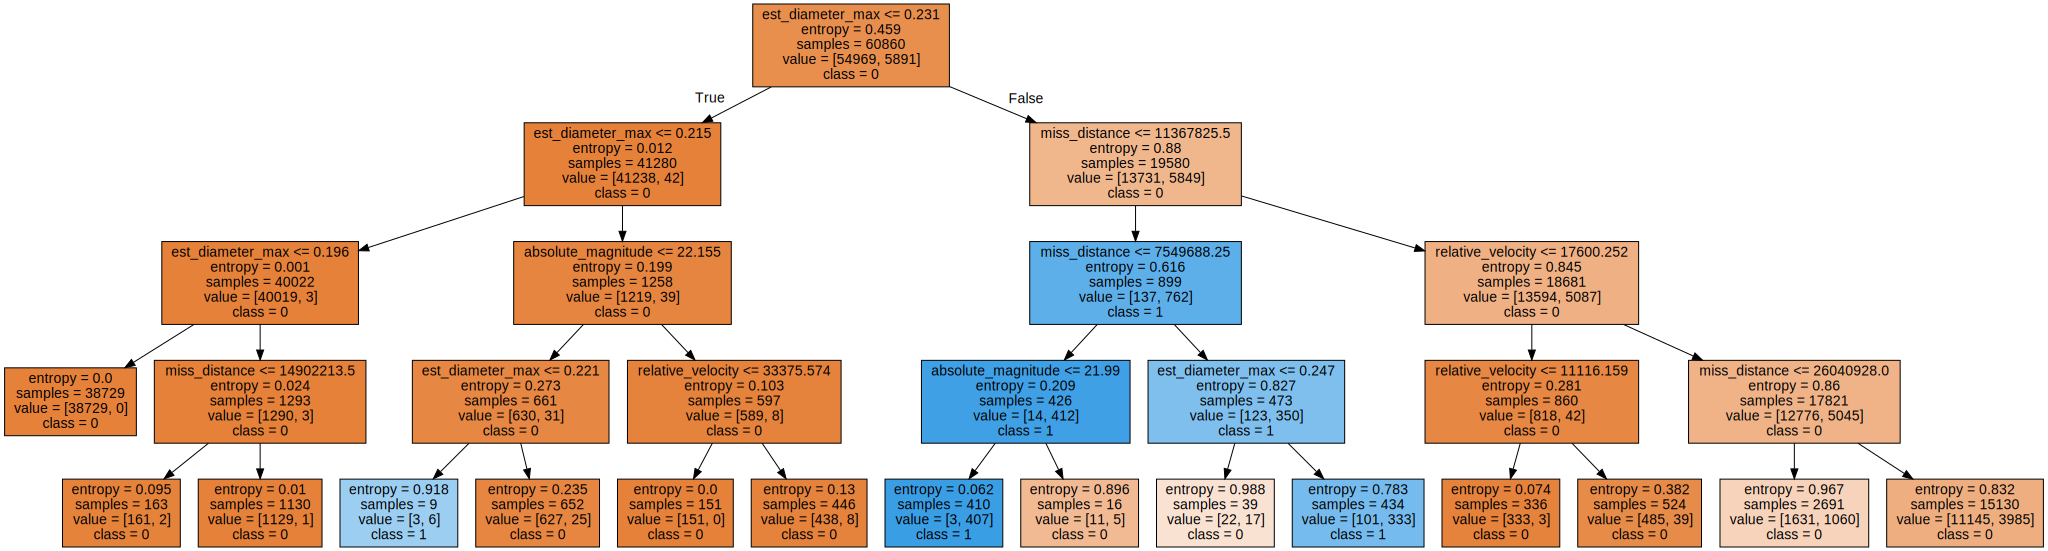

In [38]:
graph = Source(tree.export_graphviz(
    clf_tree, #
    out_file=None, 
    feature_names=list(X_train), #
    class_names=['0', '1'], #
    filled = True))
display(SVG(graph.pipe(format='svg')))

## Случайный лес

In [39]:
from sklearn.ensemble import RandomForestClassifier

In [40]:
clf_random_forest = RandomForestClassifier(criterion='entropy')

In [41]:
param_grid = {'n_estimators' : np.arange(1, 11, 1),
        'max_depth': np.arange(1, 11, 1),
}

In [42]:
grid_search = GridSearchCV(clf_random_forest, param_grid, cv=5, refit=True)

In [43]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(criterion='entropy'),
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])})

In [44]:
grid_search.best_params_

{'max_depth': 10, 'n_estimators': 7}

In [45]:
np.nanmean(grid_search.cv_results_['mean_test_score'])

0.9115046007229709

In [46]:
grid_search.best_score_

0.9139336181399933

## Градиентый бустинг

Будем использовать библиотеку CatBoost, которую нужно предварительно установить:

In [ ]:
%pip install catboost

In [48]:
import catboost

In [49]:
clf_boosting = catboost.CatBoostClassifier(eval_metric='AUC:hints=skip_train~false')

In [50]:
param_grid = {'learning_rate': [0.1, 0.5],
        'n_estimators' : np.arange(1, 5, 1),
        'depth': np.arange(1, 5, 1),
        'l2_leaf_reg': [100, 10, 1, 0.1, 0.01] 
}

Подберем гиперпараметры и сразу обучим модель с лучшими параметрами:

In [ ]:
clf_boosting.grid_search(
    param_grid, 
    X=X_train, 
    y=y_train, 
    cv=5,
    partition_random_seed=42,
    train_size=0.8, 
    plot=False,
    refit=True
);

Результаты обучения:

In [52]:
for key in ['learning_rate', 'iterations', 'depth', 'l2_leaf_reg']:
    print(f"{key} : {clf_boosting.get_param(key)}")

learning_rate : 0.5
iterations : 4
depth : 4
l2_leaf_reg : 10


In [53]:
clf_boosting.best_score_['learn']['AUC']

0.9067814334104438

# Результаты и выбор лучшей модели

Оценка с помощью кросс-валидации по тестовым данным:

In [54]:
from sklearn.model_selection import cross_val_score

In [55]:
from time import time

In [56]:
def estimate_model(clf, X, y, cv):
  start = time()
  clf_score = cross_val_score(clf, X, y, cv=cv).mean()
  finish = time()

  return clf_score, finish-start

In [57]:
clf_tree_score, clf_tree_time = estimate_model(clf_tree, X_test, y_test, cv=5)

In [58]:
clf_random_forest_score, clf_random_forest_time = estimate_model(clf_random_forest, X_test, y_test, cv=5)

In [ ]:
clf_boosting_score, clf_boosting_time = estimate_model(clf_boosting, X_test, y_test, cv=5)

Результаты:

In [60]:
scores = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'Gradient Boosting'],
    'Score': [clf_tree_score, clf_random_forest_score, clf_boosting_score],
    'Time' : [clf_tree_time, clf_random_forest_time, clf_boosting_time]
}).sort_values(by='Score', ascending=False)

scores.reset_index(inplace=True, drop=True)

In [61]:
scores

,Model,Score,Time
0,Gradient Boosting,0.911029,0.295949
1,Random Forest,0.909861,22.385271
2,Decision Tree,0.909828,0.254524


Лучшая модель:

In [62]:
print(f"{scores['Model'][0]}: {round(scores['Score'][0], 4)}")

Gradient Boosting: 0.911
